# Time series: forecasts the future demands
- Predictive model
  - Tree-boosted model (XGBoost)
  - Lagging methods
  - Differencing transformation
  - Predict the future demand by using lagging, and demand(T+1)

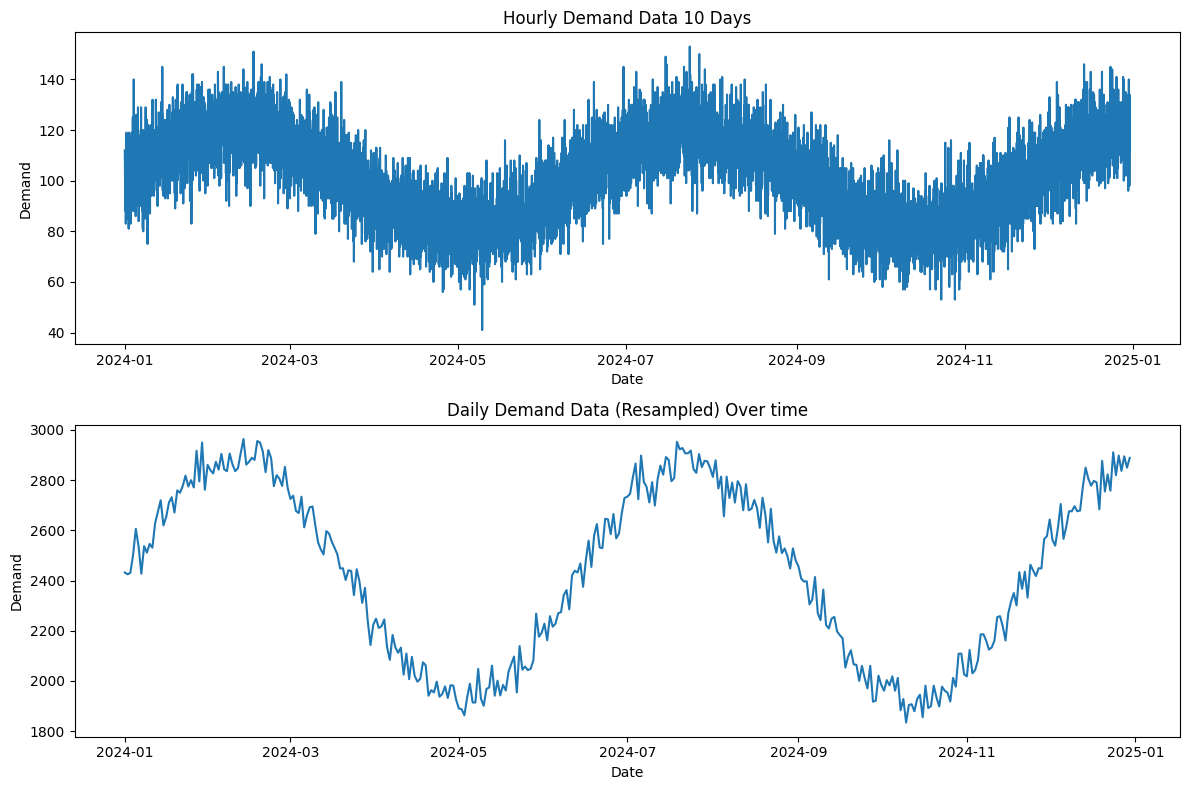

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

days = 365
hours = days * 24  # Total hours

dates = pd.date_range(start="2024-01-01 00:00:00", periods=hours, freq='h')  # Hourly dates
demand = np.round(100 + 20 * np.sin(np.linspace(0, 14, hours)) + np.random.normal(0, 10, hours))
data_hourly = pd.DataFrame({'date': dates, 'demand': demand})
data_hourly.set_index('date', inplace=True)
data_daily = data_hourly.resample('D').sum()  # Resample to daily, summing the hours


# selected_period = data_hourly[data_hourly.index < '2024-01-10']

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column of subplots

# Plot hourly data
axes[0].plot(data_hourly['demand'])
axes[0].set_title('Hourly Demand Data 10 Days')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Demand')

# Plot daily data
axes[1].plot(data_daily['demand'])
axes[1].set_title('Daily Demand Data (Resampled) Over time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Demand')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

### Helper plot demand & demand differencing with ACF values

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

def plot_time_series_and_acf(df, demand_col, diff_col, lags=7):
    """
    Plots the time series and autocorrelation function for demand and its difference.

    Args:
        df (pd.DataFrame): DataFrame containing demand and its difference.
        demand_col (str): Name of the demand column.
        diff_col (str): Name of the demand difference column.
        lags (int): Number of lags for autocorrelation plots.
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots

    # Plot demand and demand difference time series
    axes[0, 0].plot(df.index, df[demand_col])
    axes[0, 0].set_title('Demand')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Demand Value')
    axes[0, 0].grid(True)

    axes[0, 1].plot(df.index, df[diff_col])
    axes[0, 1].set_title('Demand Difference')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Difference Value')
    axes[0, 1].grid(True)

    # Plot autocorrelation functions
    plot_acf(df[demand_col], lags=lags, ax=axes[1, 0])
    axes[1, 0].set_title('Autocorrelation (Demand)')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('Autocorrelation')
    axes[1, 0].grid(True)

    plot_acf(df[diff_col].dropna(), lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation (Demand Difference)')
    axes[1, 1].set_xlabel('Lags')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].grid(True)

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

def perform_ljung_box_test(df, diff_col, lags=[1, 7, 21]):
    """
    Performs the Ljung-Box test on the demand difference and prints the results.

    Args:
        df (pd.DataFrame): DataFrame containing the demand difference.
        diff_col (str): Name of the demand difference column.
        lags (list): List of lags for the Ljung-Box test.
    """
    lb_test = acorr_ljungbox(df[diff_col].dropna(), lags=lags, return_df=True)
    print("Ljung-Box Test Results:\n", lb_test)

### Produce the predicted results without do differencing

In [63]:
exp_df = data_hourly

# Create Lag features
h = 24  # Use past horizon forecasting days as features
for i in range(1, h + 1):
    exp_df[f'lag_{i}'] = exp_df['demand'].shift(i)

# Drop missing values caused by lagging
exp_df.dropna(inplace=True)

train_size = int(len(exp_df) * 0.7)
train, test = exp_df[:train_size], exp_df[train_size:]
X_train, y_train = train.drop(columns=['demand']), train['demand']
X_test, y_test = test.drop(columns=['demand']), test['demand']

In [64]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mean_actual = np.mean(y_test)
mae_percentage = (mae / mean_actual) * 100

print(f'MAE: {mae:.2f} ({mae_percentage:.2f}%)')

MAE: 8.14 (8.59%)


## Produce the predicted results with do differencing

In [11]:
def run_ml_model (df, h, level, ci=1.96):    
    df['demand_diff'] = df['demand'].diff()
    plot_lags = 24
    custom_lags = [1, 12, 24]

    if level == 'daily':
       plot_lags = 7
       custom_lags = [1, 7, 21]

    # Autocorrelation and Ljung box (Check H1 hypothesis: Is differencing significant?)
    plot_time_series_and_acf(df, 'demand', 'demand_diff', plot_lags)
    perform_ljung_box_test(df, 'demand_diff', lags=custom_lags)
    
    # Create Lag features
    df = df.copy()
    for i in range(1, h + 1):
        df[f'lag_{i}'] = df['demand_diff'].shift(i)
    
    # Drop missing values caused by lagging (Handling missing values)
    df.dropna(inplace=True)

    # Split the dataset
    train_size = int(len(df) * 0.7)
    train, test = df[:train_size], df[train_size:]
    X_train, y_train = train.drop(columns=['demand', 'demand_diff']), train['demand_diff']
    X_test, y_test = test.drop(columns=['demand', 'demand_diff']), test['demand_diff']

    # BUild ML model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
    model.fit(X_train, y_train)

    # Predict the test outcomes
    y_pred_diff = model.predict(X_test)

    # Inverse differencing to recover the original scale
    y_prev_values = test['demand']
    y_pred = np.round(y_pred_diff + y_prev_values,2) 

    # Evaluate the model performance by measuring a MAE metric
    mae = mean_absolute_error(test['demand'], y_pred)
    mean_actual = np.mean(test['demand'])
    mae_percentage = (mae / mean_actual) * 100
    print(f'MAE: {mae:.2f} ({mae_percentage:.2f}%)')

    # Predict the future horizon period by applying lagging technic (T+1)  
    future_preds = []
    future_lower = []
    future_upper = []
    last_known_data = df.iloc[-(h+1):]['demand'].values.tolist()
    std_dev = np.std(test['demand'] - y_pred)  # Estimate standard deviation of residuals
    
    for _ in range(h):
        # Calculate differenced input features
        input_diffs = np.diff(last_known_data[-(h+1):])
        input_features = np.array(input_diffs).reshape(1, -1)
        
        next_day_prediction = model.predict(input_features)[0]
        # Inverse Differencing (t+1)
        pred = round(last_known_data[-1] + next_day_prediction,2)
        
        future_preds.append(pred)
        
        # Compute confidence interval (assuming normal distribution 95%)
        lower_bound = pred - ci * std_dev
        upper_bound = pred + ci * std_dev
        future_lower.append(lower_bound)
        future_upper.append(upper_bound)
        
        last_known_data.append(pred)  # Update history

    time_frame = pd.Timedelta(hours=1)
    freq = 'h'
    target_date = '2024-12-20 00:00:00'

    if level == 'daily':
        time_frame = pd.Timedelta(days=1)
        freq = 'D'
        target_date = '2024-11-01'

    # Print Future Predictions with Confidence Intervals
    future_dates = pd.date_range(start=df.index[-1] + time_frame, periods=h, freq=freq)  
    forecast_df = pd.DataFrame({'date': future_dates, 'predicted_demand': future_preds, 'lower_bound': future_lower, 'upper_bound': future_upper})
    print(forecast_df)

    target_datetime = pd.to_datetime(target_date)
    selected_record = df[df.index >= target_datetime]
    
    plt.figure(figsize=(12, 6))
    plt.plot(selected_record.index, selected_record['demand'], label='Historical Demand', color='blue')
    plt.plot(future_dates, future_preds, label='Forecasted Demand', color='red', linestyle='dashed')
    plt.fill_between(future_dates, future_lower, future_upper, color='red', alpha=0.2, label='95% Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title(f'Demand Forecasting with Confidence Intervals {level}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

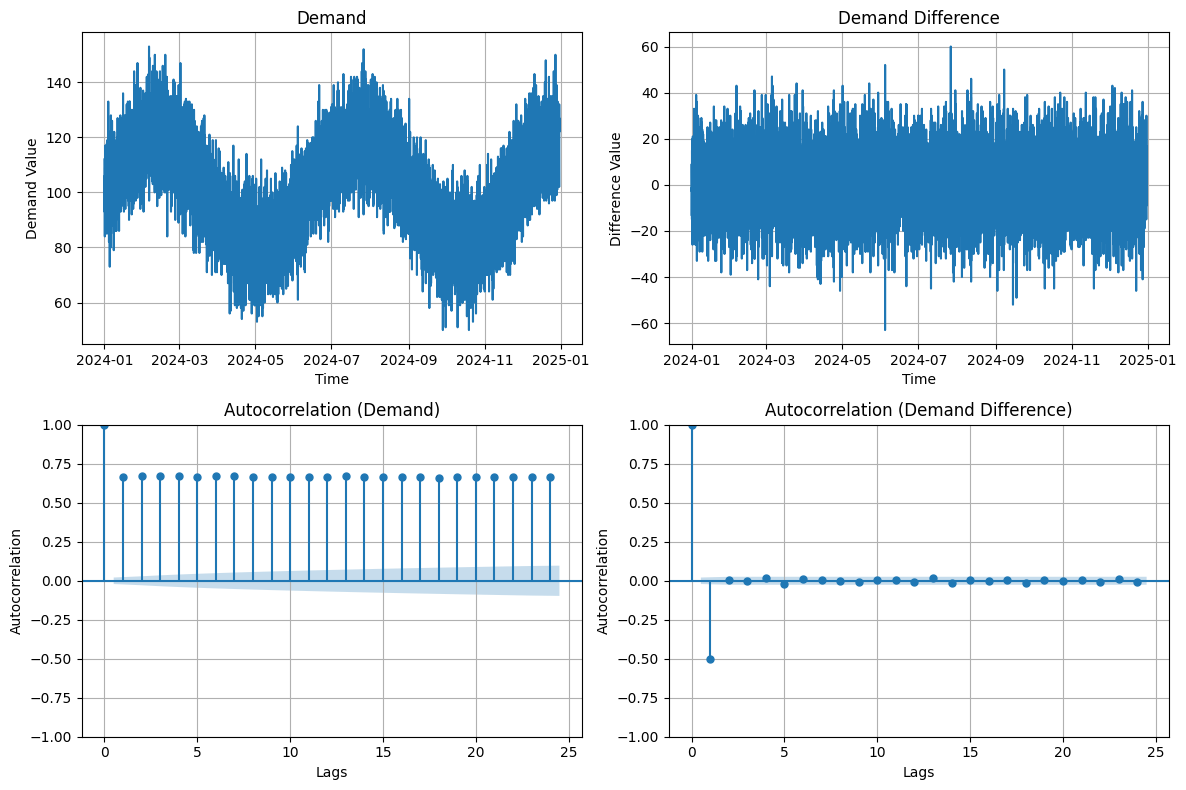

Ljung-Box Test Results:
         lb_stat  lb_pvalue
1   2216.661966        0.0
12  2224.826797        0.0
24  2234.169804        0.0
MAE: 6.38 (6.72%)
                  date  predicted_demand  lower_bound  upper_bound
0  2024-12-31 00:00:00        125.570000   109.944258   141.195741
1  2024-12-31 01:00:00        137.240005   121.614264   152.865747
2  2024-12-31 02:00:00        129.929993   114.304251   145.555734
3  2024-12-31 03:00:00        118.309998   102.684256   133.935739
4  2024-12-31 04:00:00        124.480003   108.854262   140.105745
..                 ...               ...          ...          ...
67 2025-01-02 19:00:00        123.449997   107.824255   139.075739
68 2025-01-02 20:00:00        130.860001   115.234259   146.485742
69 2025-01-02 21:00:00        127.480003   111.854262   143.105745
70 2025-01-02 22:00:00        127.919998   112.294257   143.545740
71 2025-01-02 23:00:00        125.430000   109.804259   141.055742

[72 rows x 4 columns]


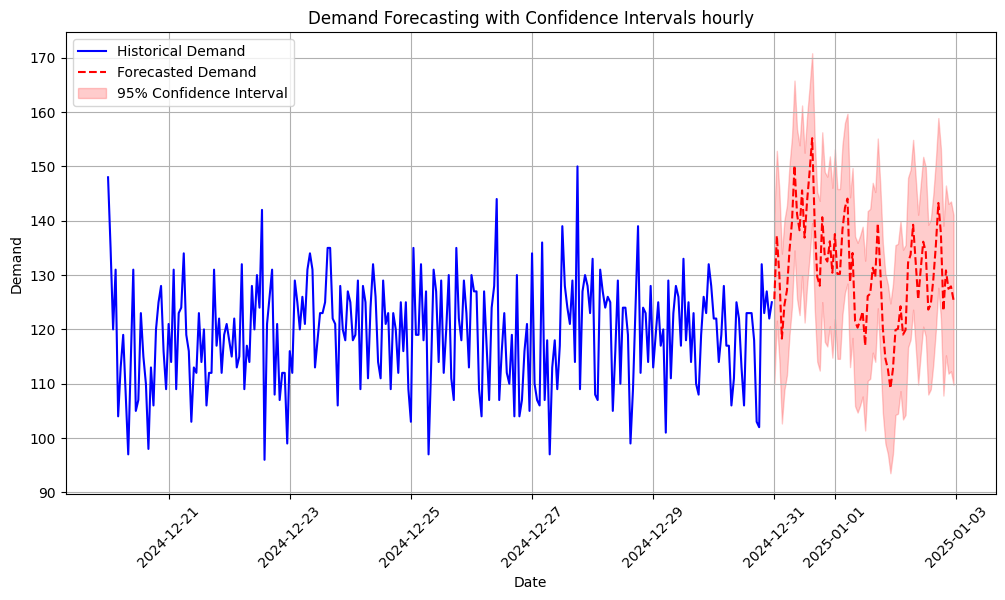

In [12]:
run_ml_model(data_hourly, 24*2, 'hourly')

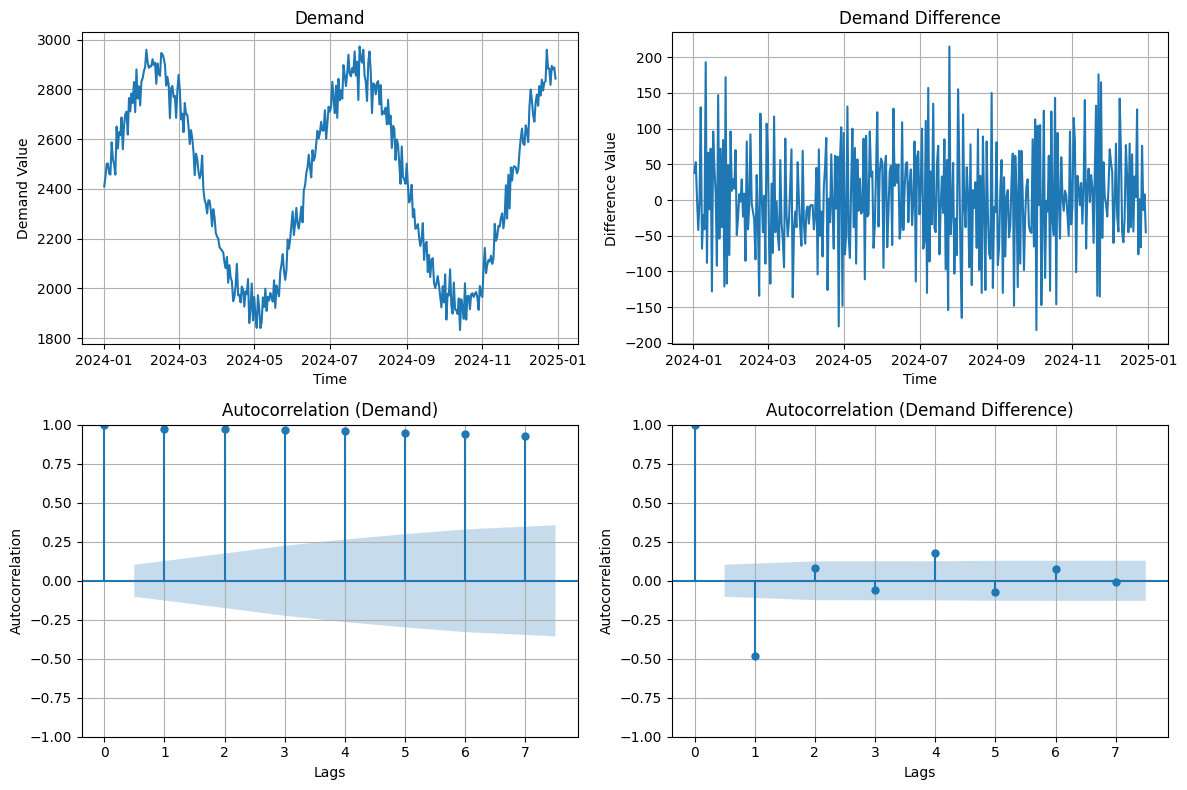

Ljung-Box Test Results:
        lb_stat     lb_pvalue
1    85.638507  2.160274e-20
7   105.556172  7.655769e-20
21  119.390175  9.237357e-16
MAE: 30.63 (1.34%)
         date  predicted_demand  lower_bound  upper_bound
0  2024-12-31       2830.070068  2755.760630  2904.379507
1  2025-01-01       2840.679932  2766.370493  2914.989370
2  2025-01-02       2816.370117  2742.060679  2890.679556
3  2025-01-03       2773.129883  2698.820444  2847.439321
4  2025-01-04       2805.500000  2731.190562  2879.809438
5  2025-01-05       2770.010010  2695.700571  2844.319448
6  2025-01-06       2712.889893  2638.580454  2787.199331
7  2025-01-07       2690.500000  2616.190562  2764.809438
8  2025-01-08       2696.689941  2622.380503  2770.999380
9  2025-01-09       2710.050049  2635.740611  2784.359487
10 2025-01-10       2706.310059  2632.000620  2780.619497
11 2025-01-11       2617.010010  2542.700571  2691.319448
12 2025-01-12       2644.320068  2570.010630  2718.629507
13 2025-01-13       2620.000

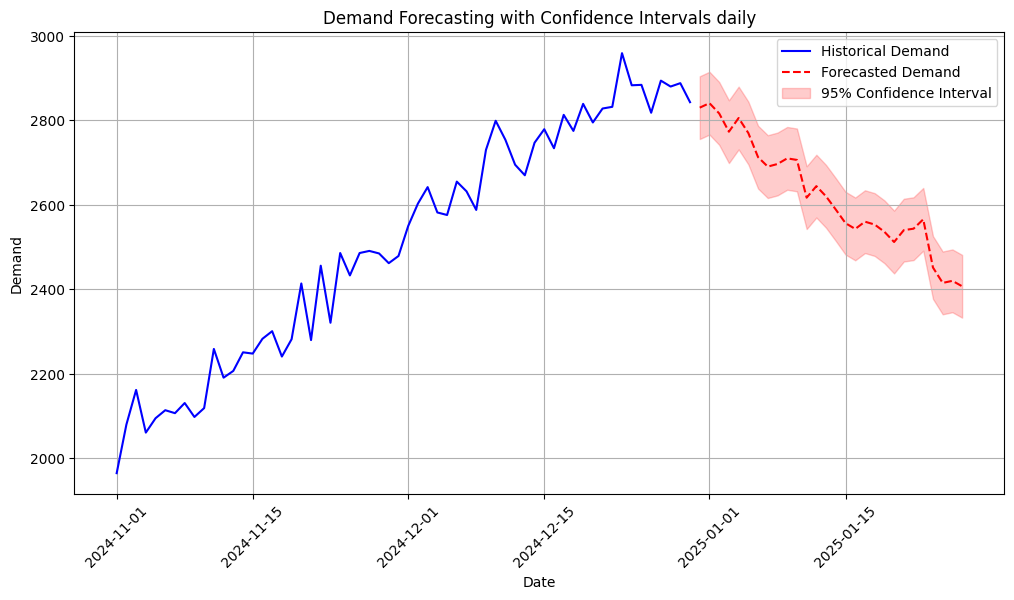

In [14]:
run_ml_model(data_daily, 21, 'daily')

https://facebook.github.io/prophet/docs/quick_start.html